# SberMarket Competition

- **Задача:** Разработать модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

- **Описание данных**
>train.csv:
>1. user_id - уникальный id пользователя
>1. order_completed_at - дата заказа
>1. cart - список уникальных категорий (category_id), из которых состоял заказ

>sample_submission.csv:
>1. id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'
>1. target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

- **План работ**
1.  Загрузка данных
1.  Исследование данныз
1.  Подготовка данных
1.  Разработка модели
1.  Итог


# Загрузка данных

In [1]:
# импорт основных библиотек
import time
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import (ShuffleSplit, train_test_split, cross_val_score)
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier)

from catboost import CatBoostClassifier


In [2]:
# загрузка данных
try:
    df_train = pd.read_csv('/kaggle/input/sbermarket-internship-competition/train.csv')
    df_submit = pd.read_csv('/kaggle/input/sbermarket-internship-competition/sample_submission.csv')
except:
    df_train = pd.read_csv('train.csv')
    df_submit = pd.read_csv('sample_submission.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [4]:
df_train.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [5]:
 df_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [6]:
df_submit.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


**Вывод:** 2 датасета, один с общими данными, другой как пример итогового результата. Данные переданы без пропусков.

# Исследование данных

In [7]:
df_s = df_train.copy()

In [8]:
# Топ 20 юзеров по количеству заказов
order_c = df_s.groupby('user_id')['cart'].count().sort_values(ascending = False)
order_c[:20]

user_id
380     3508
105     2833
84      2610
3918    2566
1156    2357
2196    2296
918     2288
2711    2286
606     2177
6102    2164
772     2128
1096    2112
260     2110
3728    2098
52      2080
140     2015
458     2008
78      1946
1325    1941
2428    1936
Name: cart, dtype: int64

In [9]:
print('Всего заказаных товаров = ',order_c.sum())
print('Среднее кол-во заказанных товаров на 1 пользователя = ',order_c.mean())
print('Медианное кол-во заказанных товаров на 1 пользователя = ',order_c.median())

Всего заказаных товаров =  3123064
Среднее кол-во заказанных товаров на 1 пользователя =  156.1532
Медианное кол-во заказанных товаров на 1 пользователя =  88.0


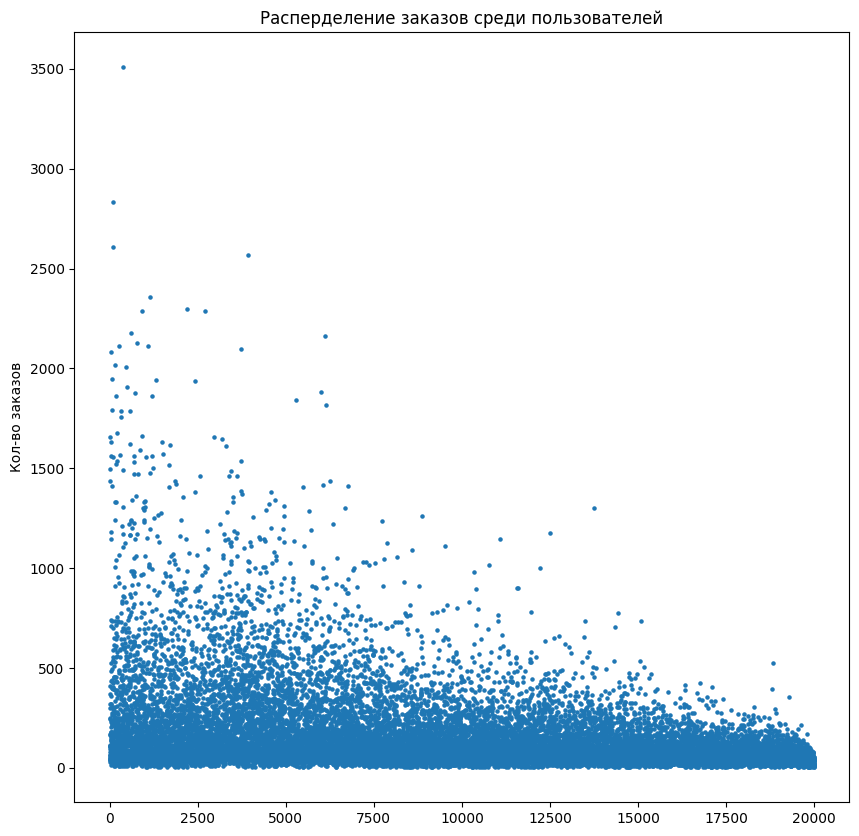

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(order_c.index, order_c.values, s =  5)

plt.title('Расперделение заказов среди пользователей')
plt.ylabel('Кол-во заказов')
plt.show()

В данных наблюдается большое количетсво шума. Проведем дополнительные исследования.

In [11]:
def year_tr(x):
    xs = x.split('-')
    return(xs[0])

In [12]:
df_s['year'] = df_s['order_completed_at'].apply(lambda x: year_tr(x))

In [13]:
order_y = df_s.groupby('year')['cart'].count().sort_values(ascending = False)
order_y

year
2020    2483837
2019     603398
2018      25464
2017       8938
2016       1375
2015         52
Name: cart, dtype: int64

In [14]:
print('Количетсво уникальных позиций товаров = ', len(df_s['cart'].unique()))

Количетсво уникальных позиций товаров =  881


**Вывод:** Видимо аномально большое количество заказов появилось благодоря накопительному эффекту за все года, и скорее всего это сделали самые первые пользователи. В дальнейшем по условию задачи дата и время следующего заказа не учитывается.

# Подготовка данных

Тут воспользовался примером https://www.kaggle.com/code/paveltrusov/next-order-prediction . Из всех найденных примеров данный вид подоготовки данных имеет на выходе более приспособленный вид для классического ML, чем я и собираюсь пользоваться. 

In [15]:
# временные колонки

# сначала идет кодировка категориального признака 'cart', параметры prefix='', prefix_sep='' 
# нужны для наименования закодированных колонок
train_raw = pd.get_dummies(df_train, columns = ['cart'], prefix='', prefix_sep='', dtype='bool')
print(train_raw.head())

# группировка по 2 колонкам c возвращением True или False через pandas.any()
# функция проверяет наличие True, и возвращает его если нашла
train_raw = train_raw.groupby(['user_id', 'order_completed_at']).any().reset_index()
print(train_raw.head())

   user_id   order_completed_at      0      1      2      3      4      5  \
0        2  2015-03-22 09:25:46  False  False  False  False  False  False   
1        2  2015-03-22 09:25:46  False  False  False  False  False  False   
2        2  2015-03-22 09:25:46  False  False  False  False  False  False   
3        2  2015-03-22 09:25:46  False  False  False  False  False  False   
4        2  2015-03-22 09:25:46  False  False  False  False  False  False   

       6      7  ...    871    872    873    874    875    876    877    878  \
0  False  False  ...  False  False  False  False  False  False  False  False   
1  False  False  ...  False  False  False  False  False  False  False  False   
2  False  False  ...  False  False  False  False  False  False  False  False   
3  False  False  ...  False  False  False  False  False  False  False  False   
4  False  False  ...  False  False  False  False  False  False  False  False   

     879    880  
0  False  False  
1  False  False  
2 

In [16]:
# считаемт кумулятивную сумму заказов каждого пользователя и удаляем дату
train_raw['order_number'] = train_raw.groupby(['user_id']).cumcount()
train_raw = train_raw.drop('order_completed_at', axis=1)
train_raw.head()

,user_id,0,1,2,3,4,5,6,7,8,...,872,873,874,875,876,877,878,879,880,order_number
0,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,0,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [17]:
# Ищем последний заказ пользователя через .transform(max) (ищем максимальное последнее значение)
# и переводим в bool сравнением с ранее созданным столбцом
last_order = train_raw.groupby(['user_id'])['order_number'].transform(max) == train_raw['order_number']
last_order

/tmp/ipykernel_34/18714821.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  last_order = train_raw.groupby(['user_id'])['order_number'].transform(max) == train_raw['order_number']


0         False
1         False
2          True
3         False
4         False
          ...  
209401    False
209402     True
209403    False
209404    False
209405     True
Name: order_number, Length: 209406, dtype: bool

In [18]:
# создаем 2 выборки в одной будут факты заказов товара, в другом таргет (будет заказ или нет)
# в train выбираем все False значения через ~last_order, группируем, суммируем
# в valid оставшиеся значения
order = train_raw[~last_order].groupby('user_id').sum().reset_index()
target = train_raw[last_order].reset_index(drop=True)

In [19]:
order.head()

,user_id,0,1,2,3,4,5,6,7,8,...,872,873,874,875,876,877,878,879,880,order_number
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28
2,2,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,91
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,4,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,21


In [20]:
target.head()

,user_id,0,1,2,3,4,5,6,7,8,...,872,873,874,875,876,877,878,879,880,order_number
0,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,8
2,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,14
3,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6
4,4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,7


In [21]:
# при помощи pd.melt переводим стобцы в таблице в строки.
# в таблице target у нас отображаются таргеты
order_melt = pd.melt(order, id_vars=['user_id'], var_name='category', value_name='ordered')
target_melt = pd.melt(target, id_vars=['user_id'], var_name='category', value_name='target')

In [22]:
order_melt.head()

,user_id,category,ordered
0,0,0,0
1,1,0,0
2,2,0,1
3,3,0,0
4,4,0,0


In [23]:
target_melt.head()

,user_id,category,target
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


In [24]:
# Копируем train_melt, тем самым начинаем собирать датасет для обучения моделей
Train = order_melt.copy()

In [25]:
# добавляем найденные ранее количество заказов и через map, применяем свойство к
# новой колонке через map
order_number = target[['user_id', 'order_number']].set_index('user_id').squeeze()
Train['orders_total'] = Train['user_id'].map(order_number)
Train.head()

,user_id,category,ordered,orders_total
0,0,0,0,2
1,1,0,0,8
2,2,0,1,14
3,3,0,0,6
4,4,0,0,7


In [26]:
# создаём колонку с рейтингом заказа (заказ делим на общее количетсво)
Train['rating'] = Train['ordered'] / Train['orders_total']
Train.head()

,user_id,category,ordered,orders_total,rating
0,0,0,0,2,0.000000
1,1,0,0,8,0.000000
2,2,0,1,14,0.071429
3,3,0,0,6,0.000000
4,4,0,0,7,0.000000


In [27]:
# создаем колонку аналог как у датафрема sanple_submission
Train['id'] = Train['user_id'].astype(str) + ';' + Train['category']
Train.head()

,user_id,category,ordered,orders_total,rating,id
0,0,0,0,2,0.000000,0;0
1,1,0,0,8,0.000000,1;0
2,2,0,1,14,0.071429,2;0
3,3,0,0,6,0.000000,3;0
4,4,0,0,7,0.000000,4;0


In [28]:
target

,user_id,0,1,2,3,4,5,6,7,8,...,872,873,874,875,876,877,878,879,880,order_number
0,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,8
2,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,14
3,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6
4,4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
19996,19996,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
19997,19997,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
19998,19998,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [29]:
# добавляем таргет и переводим в int
Train['target'] = target_melt['target'].astype('int')
Train.head()

,user_id,category,ordered,orders_total,rating,id,target
0,0,0,0,2,0.000000,0;0,0
1,1,0,0,8,0.000000,1;0,0
2,2,0,1,14,0.071429,2;0,0
3,3,0,0,6,0.000000,3;0,0
4,4,0,0,7,0.000000,4;0,0


In [30]:
#удаляем пользователей и категории, которые не представлены в файле sample_submission.csv
Train = Train[Train.id.isin(df_submit.id.unique())].reset_index(drop=True)

In [31]:
# добавляем заказы для всех пользователей и через map, применяем свойство к
# новой колонке через map
total_ordered = Train.groupby('category')['ordered'].sum()
Train['total_ordered'] = Train['category'].map(total_ordered)

In [32]:
Train.head()

,user_id,category,ordered,orders_total,rating,id,target,total_ordered
0,7,0,0,10,0.000000,7;0,1,12922
1,8,0,1,7,0.142857,8;0,0,12922
2,9,0,1,45,0.022222,9;0,0,12922
3,12,0,1,20,0.050000,12;0,1,12922
4,13,0,3,16,0.187500,13;0,0,12922


In [33]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        790449 non-null  int64  
 1   category       790449 non-null  object 
 2   ordered        790449 non-null  int64  
 3   orders_total   790449 non-null  int64  
 4   rating         790449 non-null  float64
 5   id             790449 non-null  object 
 6   target         790449 non-null  int64  
 7   total_ordered  790449 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 48.2+ MB


In [34]:
Train.groupby('target')['target'].count()

target
0    603931
1    186518
Name: target, dtype: int64

**Вывод:** Тренировачный датасет сформирован. Всего в трейне 790 тыс. строк. Наблюдается дисбаланс классов.

# Обучение моделей

In [35]:
# делим датасет
train, test = train_test_split(Train, test_size = 0.2, random_state = 42)

In [36]:
# подготовка выборок
X_train = train.drop(['target','user_id', 'category', 'id'], axis = 1)
y_train = train['target']

X_test = test.drop(['target','user_id', 'category', 'id'], axis = 1)
y_test = test['target']

In [37]:
X_train.shape, X_test.shape

((632359, 4), (158090, 4))

In [38]:
# для эксперемента сохраним пару колонок как категориальные
cat_futeres = ['ordered', 'orders_total']

In [39]:
%%time
# baseline catboost
model = CatBoostClassifier(random_state = 42, verbose = 0)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(f'Предсказание базовой модели = {f1_score(y_test, pred)}')

Предсказание базовой модели = 0.5765017911270324
CPU times: user 3min 45s, sys: 4.31 s, total: 3min 49s
Wall time: 59.4 s


**Результат базовой модели без перебора параметров равняется 0.575, в лидерборде базовая модель даёт скор 0.35367**

### Catboost 

In [40]:

import datetime
 
current_time = datetime.datetime.now().time()
print(current_time)

19:41:41.347765


In [43]:
def CatBoostClassifier_p1(trial):
    
#     параметры
    iterations = trial.suggest_int("iterations", 5, 1000)
    depth = trial.suggest_int("depth", 1, 16)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 2, 3.5)
#     auto_class_weights = trial.suggest_categorical('auto_class_weights', [True])
    cat_features = trial.suggest_categorical('cat_features', [['ordered', 'orders_total'], None])
    
    print('Выбранные параметры: ', iterations, depth, learning_rate, l2_leaf_reg, cat_features)
    
    model = CatBoostClassifier(iterations = iterations,
                               depth = depth, 
                               learning_rate = learning_rate,
#                                auto_class_weights = True,
                               l2_leaf_reg = l2_leaf_reg,
#                                max_leaves = max_leaves,
                               cat_features = cat_features,
                              random_state = 42, verbose = 0, task_type = 'GPU')
    
#     через кросс-валидацию смотрим на результат выбранных параметров
    # cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

#     pipeline = Pipeline([
#         ("scaler", StandardScaler()),
#         ("model", model) 
#     ])
    
    current_time = datetime.datetime.now().time()
    print('начало обучения: ', current_time)
    
    start = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring = 'f1',  cv=2, verbose = 1)
    
    end = time.time()
    
    print(f'Время обучения составило = {round(end - start, 2)} секунд')
    print()

    return scores.mean()

In [56]:
study = optuna.create_study(direction="maximize")
study.optimize(CatBoostClassifier_p1, n_trials=50)
study.best_params

[I 2024-03-18 20:45:45,379] A new study created in memory with name: no-name-fec7819e-0a5f-4798-b4b8-bdd7a55d8df8
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)


Выбранные параметры:  277 5 2.585559794620465e-05 2.4224405842170267 None
начало обучения:  20:45:45.382858


[I 2024-03-18 20:45:50,959] Trial 0 finished with value: 0.5762238494906475 and parameters: {'iterations': 277, 'depth': 5, 'learning_rate': 2.585559794620465e-05, 'l2_leaf_reg': 2.4224405842170267, 'cat_features': None}. Best is trial 0 with value: 0.5762238494906475.


Время обучения составило = 5.58 секунд

Выбранные параметры:  389 4 0.014415620123026099 3.3069716773657043 ['ordered', 'orders_total']
начало обучения:  20:45:50.962526


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 20:46:05,777] Trial 1 finished with value: 0.5757306223966021 and parameters: {'iterations': 389, 'depth': 4, 'learning_rate': 0.014415620123026099, 'l2_leaf_reg': 3.3069716773657043, 'cat_features': ['ordered', 'orders_total']}. Best is trial 0 with value: 0.5762238494906475.


Время обучения составило = 14.81 секунд

Выбранные параметры:  770 5 8.279037658952713e-05 2.614268383268859 ['ordered', 'orders_total']
начало обучения:  20:46:05.779801


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 20:46:36,057] Trial 2 finished with value: 0.5743631223751275 and parameters: {'iterations': 770, 'depth': 5, 'learning_rate': 8.279037658952713e-05, 'l2_leaf_reg': 2.614268383268859, 'cat_features': ['ordered', 'orders_total']}. Best is trial 0 with value: 0.5762238494906475.


Время обучения составило = 30.28 секунд

Выбранные параметры:  113 7 0.002294724100990911 2.6362970325091677 None
начало обучения:  20:46:36.060038


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 20:46:39,348] Trial 3 finished with value: 0.580704896691985 and parameters: {'iterations': 113, 'depth': 7, 'learning_rate': 0.002294724100990911, 'l2_leaf_reg': 2.6362970325091677, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 3.29 секунд

Выбранные параметры:  781 4 0.0001692042816459985 2.5383547909422144 None
начало обучения:  20:46:39.351602


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 20:46:51,589] Trial 4 finished with value: 0.577860541387668 and parameters: {'iterations': 781, 'depth': 4, 'learning_rate': 0.0001692042816459985, 'l2_leaf_reg': 2.5383547909422144, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 12.24 секунд

Выбранные параметры:  984 15 0.48771194181637273 2.363210393792319 None
начало обучения:  20:46:51.592303


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 20:58:22,247] Trial 5 finished with value: 0.5691447702992183 and parameters: {'iterations': 984, 'depth': 15, 'learning_rate': 0.48771194181637273, 'l2_leaf_reg': 2.363210393792319, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 690.65 секунд

Выбранные параметры:  105 9 0.3453468918471213 2.944754492110645 None
начало обучения:  20:58:22.250252


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 20:58:26,331] Trial 6 finished with value: 0.5748917602696197 and parameters: {'iterations': 105, 'depth': 9, 'learning_rate': 0.3453468918471213, 'l2_leaf_reg': 2.944754492110645, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 4.08 секунд

Выбранные параметры:  894 13 0.00579610098768029 2.2079408972146224 ['ordered', 'orders_total']
начало обучения:  20:58:26.334407


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:10:31,637] Trial 7 finished with value: 0.5754268988985236 and parameters: {'iterations': 894, 'depth': 13, 'learning_rate': 0.00579610098768029, 'l2_leaf_reg': 2.2079408972146224, 'cat_features': ['ordered', 'orders_total']}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 725.3 секунд

Выбранные параметры:  359 10 0.0021468994129987184 3.404850938376299 None
начало обучения:  21:10:31.639922


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:10:48,899] Trial 8 finished with value: 0.5744216437023892 and parameters: {'iterations': 359, 'depth': 10, 'learning_rate': 0.0021468994129987184, 'l2_leaf_reg': 3.404850938376299, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 17.26 секунд

Выбранные параметры:  949 1 0.0022169241652121915 2.814571897454244 None
начало обучения:  21:10:48.902419


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:10:59,519] Trial 9 finished with value: 0.5129166560100669 and parameters: {'iterations': 949, 'depth': 1, 'learning_rate': 0.0022169241652121915, 'l2_leaf_reg': 2.814571897454244, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 10.62 секунд

Выбранные параметры:  58 12 0.016593719481854875 3.033773221298405 ['ordered', 'orders_total']
начало обучения:  21:10:59.571681


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:11:08,482] Trial 10 finished with value: 0.5756862187787228 and parameters: {'iterations': 58, 'depth': 12, 'learning_rate': 0.016593719481854875, 'l2_leaf_reg': 3.033773221298405, 'cat_features': ['ordered', 'orders_total']}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 8.91 секунд

Выбранные параметры:  659 7 0.0002960557690048084 2.59662421695649 None
начало обучения:  21:11:08.521698


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:11:22,615] Trial 11 finished with value: 0.5802669649575416 and parameters: {'iterations': 659, 'depth': 7, 'learning_rate': 0.0002960557690048084, 'l2_leaf_reg': 2.59662421695649, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 14.09 секунд

Выбранные параметры:  573 8 0.0006150937498058847 2.0089204044491957 None
начало обучения:  21:11:22.648972


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:11:37,220] Trial 12 finished with value: 0.5774992355819227 and parameters: {'iterations': 573, 'depth': 8, 'learning_rate': 0.0006150937498058847, 'l2_leaf_reg': 2.0089204044491957, 'cat_features': None}. Best is trial 3 with value: 0.580704896691985.


Время обучения составило = 14.57 секунд

Выбранные параметры:  591 7 1.0667352615825173e-05 2.6774842329018114 None
начало обучения:  21:11:37.260528


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:11:49,694] Trial 13 finished with value: 0.5815773080345006 and parameters: {'iterations': 591, 'depth': 7, 'learning_rate': 1.0667352615825173e-05, 'l2_leaf_reg': 2.6774842329018114, 'cat_features': None}. Best is trial 13 with value: 0.5815773080345006.


Время обучения составило = 12.43 секунд

Выбранные параметры:  204 7 1.1262278977519132e-05 3.060178692438891 None
начало обучения:  21:11:49.731226


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:11:55,495] Trial 14 finished with value: 0.5815994520834415 and parameters: {'iterations': 204, 'depth': 7, 'learning_rate': 1.1262278977519132e-05, 'l2_leaf_reg': 3.060178692438891, 'cat_features': None}. Best is trial 14 with value: 0.5815994520834415.


Время обучения составило = 5.76 секунд

Выбранные параметры:  505 1 1.022855147619762e-05 3.165091977964773 None
начало обучения:  21:11:55.535046


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:12:01,514] Trial 15 finished with value: 0.42961906961472773 and parameters: {'iterations': 505, 'depth': 1, 'learning_rate': 1.022855147619762e-05, 'l2_leaf_reg': 3.165091977964773, 'cat_features': None}. Best is trial 14 with value: 0.5815994520834415.


Время обучения составило = 5.98 секунд

Выбранные параметры:  236 11 3.814035610569393e-05 2.8426434828853853 None
начало обучения:  21:12:01.553707


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:12:19,657] Trial 16 finished with value: 0.576888375656563 and parameters: {'iterations': 236, 'depth': 11, 'learning_rate': 3.814035610569393e-05, 'l2_leaf_reg': 2.8426434828853853, 'cat_features': None}. Best is trial 14 with value: 0.5815994520834415.


Время обучения составило = 18.1 секунд

Выбранные параметры:  447 6 1.0404894547947043e-05 3.138419549945209 None
начало обучения:  21:12:19.691393


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:12:28,389] Trial 17 finished with value: 0.5823502232701044 and parameters: {'iterations': 447, 'depth': 6, 'learning_rate': 1.0404894547947043e-05, 'l2_leaf_reg': 3.138419549945209, 'cat_features': None}. Best is trial 17 with value: 0.5823502232701044.


Время обучения составило = 8.7 секунд

Выбранные параметры:  409 16 0.1173889350566725 3.169877269148935 ['ordered', 'orders_total']
начало обучения:  21:12:28.436437


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:12,727] Trial 18 finished with value: 0.5748921820176107 and parameters: {'iterations': 409, 'depth': 16, 'learning_rate': 0.1173889350566725, 'l2_leaf_reg': 3.169877269148935, 'cat_features': ['ordered', 'orders_total']}. Best is trial 17 with value: 0.5823502232701044.


Время обучения составило = 2444.29 секунд

Выбранные параметры:  222 3 5.5251230602411885e-05 3.0756231076373024 None
начало обучения:  21:53:12.756890


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:17,408] Trial 19 finished with value: 0.5810507739657076 and parameters: {'iterations': 222, 'depth': 3, 'learning_rate': 5.5251230602411885e-05, 'l2_leaf_reg': 3.0756231076373024, 'cat_features': None}. Best is trial 17 with value: 0.5823502232701044.


Время обучения составило = 4.65 секунд

Выбранные параметры:  13 6 0.0005420465639240405 3.4960576532999896 None
начало обучения:  21:53:17.449358


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:19,398] Trial 20 finished with value: 0.5845827592627899 and parameters: {'iterations': 13, 'depth': 6, 'learning_rate': 0.0005420465639240405, 'l2_leaf_reg': 3.4960576532999896, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 1.95 секунд

Выбранные параметры:  30 6 0.0005256170916843711 3.4579601095575105 None
начало обучения:  21:53:19.430588


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:21,691] Trial 21 finished with value: 0.5831501151225333 and parameters: {'iterations': 30, 'depth': 6, 'learning_rate': 0.0005256170916843711, 'l2_leaf_reg': 3.4579601095575105, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.26 секунд

Выбранные параметры:  11 5 0.0002959896010472668 3.469145855966344 None
начало обучения:  21:53:21.731669


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:23,924] Trial 22 finished with value: 0.5760623474289163 and parameters: {'iterations': 11, 'depth': 5, 'learning_rate': 0.0002959896010472668, 'l2_leaf_reg': 3.469145855966344, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.19 секунд

Выбранные параметры:  132 3 0.0009741034459580999 3.3262769503545373 None
начало обучения:  21:53:23.967215


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:26,974] Trial 23 finished with value: 0.5715454068014523 and parameters: {'iterations': 132, 'depth': 3, 'learning_rate': 0.0009741034459580999, 'l2_leaf_reg': 3.3262769503545373, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 3.01 секунд

Выбранные параметры:  26 9 0.00013146721806075226 3.4805157138360205 None
начало обучения:  21:53:27.015665


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:29,574] Trial 24 finished with value: 0.5783417180092851 and parameters: {'iterations': 26, 'depth': 9, 'learning_rate': 0.00013146721806075226, 'l2_leaf_reg': 3.4805157138360205, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.56 секунд

Выбранные параметры:  301 6 0.03654078312327415 3.262672519019969 None
начало обучения:  21:53:29.614332


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:36,240] Trial 25 finished with value: 0.5766779062722323 and parameters: {'iterations': 301, 'depth': 6, 'learning_rate': 0.03654078312327415, 'l2_leaf_reg': 3.262672519019969, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 6.63 секунд

Выбранные параметры:  187 3 0.0005688886093040981 3.375712447358972 None
начало обучения:  21:53:36.289116


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:39,643] Trial 26 finished with value: 0.5810507739657076 and parameters: {'iterations': 187, 'depth': 3, 'learning_rate': 0.0005688886093040981, 'l2_leaf_reg': 3.375712447358972, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 3.35 секунд

Выбранные параметры:  159 6 0.006442614065358177 3.21666893689733 ['ordered', 'orders_total']
начало обучения:  21:53:39.683894


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:46,387] Trial 27 finished with value: 0.5725395574238276 and parameters: {'iterations': 159, 'depth': 6, 'learning_rate': 0.006442614065358177, 'l2_leaf_reg': 3.21666893689733, 'cat_features': ['ordered', 'orders_total']}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 6.7 секунд

Выбранные параметры:  465 8 0.0013497494681813569 3.473405938886832 None
начало обучения:  21:53:46.429905


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:53:58,328] Trial 28 finished with value: 0.5761126373935219 and parameters: {'iterations': 465, 'depth': 8, 'learning_rate': 0.0013497494681813569, 'l2_leaf_reg': 3.473405938886832, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 11.9 секунд

Выбранные параметры:  300 6 2.572983400524204e-05 3.3725252068266447 None
начало обучения:  21:53:58.361138


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:05,020] Trial 29 finished with value: 0.5826369664656897 and parameters: {'iterations': 300, 'depth': 6, 'learning_rate': 2.572983400524204e-05, 'l2_leaf_reg': 3.3725252068266447, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 6.66 секунд

Выбранные параметры:  314 10 2.7762288722300038e-05 2.9619134450444444 None
начало обучения:  21:54:05.062163


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:20,690] Trial 30 finished with value: 0.5777781895361794 and parameters: {'iterations': 314, 'depth': 10, 'learning_rate': 2.7762288722300038e-05, 'l2_leaf_reg': 2.9619134450444444, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 15.63 секунд

Выбранные параметры:  71 6 1.890246182352616e-05 3.3865682602921003 None
начало обучения:  21:54:20.734907


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:23,482] Trial 31 finished with value: 0.5825543928269119 and parameters: {'iterations': 71, 'depth': 6, 'learning_rate': 1.890246182352616e-05, 'l2_leaf_reg': 3.3865682602921003, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.75 секунд

Выбранные параметры:  75 5 7.272014247105429e-05 3.348355408722254 None
начало обучения:  21:54:23.529944


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:26,136] Trial 32 finished with value: 0.5757034214671226 and parameters: {'iterations': 75, 'depth': 5, 'learning_rate': 7.272014247105429e-05, 'l2_leaf_reg': 3.348355408722254, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.61 секунд

Выбранные параметры:  9 4 2.6534561942250135e-05 3.277861293762797 None
начало обучения:  21:54:26.171182


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:28,251] Trial 33 finished with value: 0.5780916483719942 and parameters: {'iterations': 9, 'depth': 4, 'learning_rate': 2.6534561942250135e-05, 'l2_leaf_reg': 3.277861293762797, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.08 секунд

Выбранные параметры:  90 4 0.0002680512406878818 3.3935560648539784 ['ordered', 'orders_total']
начало обучения:  21:54:28.295616


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:33,185] Trial 34 finished with value: 0.5755898276941728 and parameters: {'iterations': 90, 'depth': 4, 'learning_rate': 0.0002680512406878818, 'l2_leaf_reg': 3.3935560648539784, 'cat_features': ['ordered', 'orders_total']}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 4.89 секунд

Выбранные параметры:  272 6 0.00011224171836546833 3.4895281734186567 None
начало обучения:  21:54:33.231547


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:39,937] Trial 35 finished with value: 0.582587576404415 and parameters: {'iterations': 272, 'depth': 6, 'learning_rate': 0.00011224171836546833, 'l2_leaf_reg': 3.4895281734186567, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 6.7 секунд

Выбранные параметры:  269 8 0.00015547580339039617 3.2745917389172345 None
начало обучения:  21:54:39.983019


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:48,074] Trial 36 finished with value: 0.5796216542171347 and parameters: {'iterations': 269, 'depth': 8, 'learning_rate': 0.00015547580339039617, 'l2_leaf_reg': 3.2745917389172345, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 8.09 секунд

Выбранные параметры:  163 2 8.319292087234226e-05 3.490998960067602 None
начало обучения:  21:54:48.119597


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:54:51,142] Trial 37 finished with value: 0.5128297001578389 and parameters: {'iterations': 163, 'depth': 2, 'learning_rate': 8.319292087234226e-05, 'l2_leaf_reg': 3.490998960067602, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 3.02 секунд

Выбранные параметры:  367 5 0.000693079309058472 3.2307729792229805 ['ordered', 'orders_total']
начало обучения:  21:54:51.188151


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:07,468] Trial 38 finished with value: 0.5738237984114536 and parameters: {'iterations': 367, 'depth': 5, 'learning_rate': 0.000693079309058472, 'l2_leaf_reg': 3.2307729792229805, 'cat_features': ['ordered', 'orders_total']}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 16.28 секунд

Выбранные параметры:  257 5 0.00032292081378461845 2.4663099673271534 None
начало обучения:  21:55:07.516065


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:13,149] Trial 39 finished with value: 0.5786327102400257 and parameters: {'iterations': 257, 'depth': 5, 'learning_rate': 0.00032292081378461845, 'l2_leaf_reg': 2.4663099673271534, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 5.63 секунд

Выбранные параметры:  338 7 0.00011296952604118923 3.4188601115332378 None
начало обучения:  21:55:13.195627


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:20,772] Trial 40 finished with value: 0.5815241394031079 and parameters: {'iterations': 338, 'depth': 7, 'learning_rate': 0.00011296952604118923, 'l2_leaf_reg': 3.4188601115332378, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 7.58 секунд

Выбранные параметры:  107 6 3.464981523778484e-05 3.3404710072164256 None
начало обучения:  21:55:20.807481


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:23,762] Trial 41 finished with value: 0.5827593982167376 and parameters: {'iterations': 107, 'depth': 6, 'learning_rate': 3.464981523778484e-05, 'l2_leaf_reg': 3.3404710072164256, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.95 секунд

Выбранные параметры:  131 6 4.965553166984042e-05 3.322374061243834 None
начало обучения:  21:55:23.808133


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:27,013] Trial 42 finished with value: 0.5825749504439919 and parameters: {'iterations': 131, 'depth': 6, 'learning_rate': 4.965553166984042e-05, 'l2_leaf_reg': 3.322374061243834, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 3.2 секунд

Выбранные параметры:  45 9 2.074956172159134e-05 3.4240933611106845 None
начало обучения:  21:55:27.059139


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:29,960] Trial 43 finished with value: 0.5788996990832722 and parameters: {'iterations': 45, 'depth': 9, 'learning_rate': 2.074956172159134e-05, 'l2_leaf_reg': 3.4240933611106845, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.9 секунд

Выбранные параметры:  119 5 0.003911183485772748 3.3084932063575017 None
начало обучения:  21:55:30.005309


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:33,150] Trial 44 finished with value: 0.5778227560392686 and parameters: {'iterations': 119, 'depth': 5, 'learning_rate': 0.003911183485772748, 'l2_leaf_reg': 3.3084932063575017, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 3.14 секунд

Выбранные параметры:  180 7 0.0001925177847214642 3.485015220097005 None
начало обучения:  21:55:33.196823


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:37,314] Trial 45 finished with value: 0.5818616256267748 and parameters: {'iterations': 180, 'depth': 7, 'learning_rate': 0.0001925177847214642, 'l2_leaf_reg': 3.485015220097005, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 4.12 секунд

Выбранные параметры:  99 8 0.00047329991066975515 3.4237989416895553 ['ordered', 'orders_total']
начало обучения:  21:55:37.366958


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:43,348] Trial 46 finished with value: 0.5765046383329051 and parameters: {'iterations': 99, 'depth': 8, 'learning_rate': 0.00047329991066975515, 'l2_leaf_reg': 3.4237989416895553, 'cat_features': ['ordered', 'orders_total']}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 5.98 секунд

Выбранные параметры:  54 4 7.682109390396459e-05 3.2097811734804256 None
начало обучения:  21:55:43.397713


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:45,895] Trial 47 finished with value: 0.5780565899887797 and parameters: {'iterations': 54, 'depth': 4, 'learning_rate': 7.682109390396459e-05, 'l2_leaf_reg': 3.2097811734804256, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 2.5 секунд

Выбранные параметры:  762 6 0.0015280758866636328 3.095037331891918 None
начало обучения:  21:55:45.932443


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:55:58,976] Trial 48 finished with value: 0.5772856422249499 and parameters: {'iterations': 762, 'depth': 6, 'learning_rate': 0.0015280758866636328, 'l2_leaf_reg': 3.095037331891918, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 13.04 секунд

Выбранные параметры:  226 7 3.6662194681439795e-05 2.321814808142408 None
начало обучения:  21:55:59.023140


/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['ordered', 'orders_total'] which is of type list.
  warnings.warn(message)
[I 2024-03-18 21:56:05,077] Trial 49 finished with value: 0.5814720761993663 and parameters: {'iterations': 226, 'depth': 7, 'learning_rate': 3.6662194681439795e-05, 'l2_leaf_reg': 2.321814808142408, 'cat_features': None}. Best is trial 20 with value: 0.5845827592627899.


Время обучения составило = 6.05 секунд



NameError: name 'study_cut' is not defined

Лучшие найденные параметры для Catboost
{'iterations': 13,
 'depth': 6,
 'learning_rate': 0.0005420465639240405,
 'l2_leaf_reg': 3.4960576532999896,
 'cat_features': None}

In [45]:
%%time
# лучшие параметры для CatBoost

# model_cut = CatBoostClassifier(**study_cut.best_params)

model_cut = CatBoostClassifier(iterations = 13, depth = 6,
                               learning_rate = 2.821928371270037e-05,
                               cat_features = None,
                               random_state = 42, verbose = 0, task_type = 'GPU')
model_cut.fit(X_train, y_train)

pred = model_cut.predict(X_test)
print(f'Предсказание модели = {f1_score(y_test, pred)}')

Предсказание модели = 0.596959130462099
CPU times: user 11.8 s, sys: 2.73 s, total: 14.5 s
Wall time: 5.06 s


In [54]:
# создание дадасета для загрузки сабмита
Test = Train.copy()
 
# Test['orders_total'] = Test['orders_total'] +1
    
#добавляем последние заказы
Test['ordered'] = Test['ordered'] + Test['target']

#перерасчет заказов по группам
test_total_ordered = Test.groupby('category')['ordered'].sum()
Test['total_ordered'] = Test['category'].map(test_total_ordered)

#перерасчет рейтинга
Test['rating'] = Test['ordered'] / Test['orders_total']

Test = Test.drop('target', axis=1)
# Test.head(3)

# предсказание и создание нового датасетт
cop = Test.drop(['user_id', 'category', 'id'], axis = 1)
predictions = model_cut.predict(cop)

Test['target'] = predictions

submit = pd.merge( df_submit['id'], Test[['id', 'target']], on='id')

In [55]:
submit.to_csv('test_Catboost.csv', index = False)

**Катбуст даёт в лидерборде результат аналогичный случайному лесу**

### RandomForest

In [ ]:
%%time 
# поиск лучших параметров для RandomForest

def objective_RF(trial):

#     параметры 
    n_estimators = trial.suggest_int("n_estimators", 20, 160)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int("max_depth", 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 3, 4])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 3])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    
    model = RandomForestClassifier(n_estimators  = n_estimators ,
                               criterion = criterion ,
                                max_depth= max_depth, 
                                max_features = max_features,
                                min_samples_split = min_samples_split,
                                min_samples_leaf = min_samples_leaf,
                                   class_weight = class_weight,
                              random_state = 42, n_jobs = -1)
    
#     через кросс-валидацию смотрим на результат выбранных параметров

    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    
    start = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring='f1',  cv=cv, verbose = 1 )
    
    end = time.time()
    
    
    print(f'Время обучения составило = {round(end - start, 2)} секунд')
    print()
    
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective_RF, n_trials=50)

Лучшие параметры для случайного леса 

{'n_estimators': 62,
 'criterion': 'entropy',
 'max_depth': 13,
 'max_features': None,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'class_weight': 'balanced'}

random_state = 42  f1 = 0.6092649907010477

In [40]:
%%time
# лучшая модель RandomForestClassifier
model_rf = RandomForestClassifier(criterion='log_loss', max_depth=3, max_features=None,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=117, random_state = 42)

model_rf.fit(X_train, y_train)

pred = model_rf.predict(X_test)
print(f'Результат случайного леса = {f1_score(y_test, pred)}')

0.5968770617989885
CPU times: user 45.3 s, sys: 40.7 ms, total: 45.3 s
Wall time: 45.3 s


In [ ]:
# # создание дадасета для загрузки сабмита
# Test = Train.copy()

# #increment counter
# Test['orders_total'] 

# #add last purchase
# Test['ordered'] = Test['ordered'] + Test['target']

# #recalculate including last order
# test_total_ordered = Test.groupby('category')['ordered'].sum()
# Test['total_ordered'] = Test['category'].map(test_total_ordered)

# #recalculate including last order
# Test['rating'] = Test['ordered'] / Test['orders_total']

# Test = Test.drop('target', axis=1)
# # Test.head(3)

# cop = Test.drop(['user_id', 'category', 'id'], axis = 1)
# predictions = model.predict(cop)
# Test['target'] = predictions
# submit = pd.merge( df_submit['id'], Test[['id', 'target']], on='id')

# submit.to_csv('test_work_sub_RF_new.csv', index = False)

**На данный момент обучение дерева с такими параметрами (без корректировки вероятности) даёт скор в лидерборде равный  0.48424**

In [46]:
# калибровка вероятности для RandomForestClassifier

BestThr = -1
Bestf1 = -1

f1 = []

pred_proba = model_rf.predict_proba(X_test)

# перебор вероятности и поиск лучшей метрики f1
for thr in np.arange(0, 1, 0.01):
    classes = (pred_proba[:, 1] >= thr)
    f_1 = f1_score(y_test, classes)
    f1.append(f_1)

    if f_1 > Bestf1:
        Bestf1 = f_1
        BestThr = thr
    
    print(f'Оценка f1 на valid = {f_1}, prob = {thr} ')

print(f'Лучшая оценка f1 на valid = {Bestf1} получается при вероятности класс 1 равному {BestThr}')

Оценка f1 на valid = 0.3833890644333323, prob = 0.0 
Оценка f1 на valid = 0.3833890644333323, prob = 0.01 
Оценка f1 на valid = 0.3833890644333323, prob = 0.02 
Оценка f1 на valid = 0.3833890644333323, prob = 0.03 
Оценка f1 на valid = 0.3833890644333323, prob = 0.04 
Оценка f1 на valid = 0.4184892285602844, prob = 0.05 
Оценка f1 на valid = 0.4310907596571562, prob = 0.06 
Оценка f1 на valid = 0.4344817764274439, prob = 0.07 
Оценка f1 на valid = 0.4379231964111146, prob = 0.08 
Оценка f1 на valid = 0.456001171519346, prob = 0.09 
Оценка f1 на valid = 0.5045890603917382, prob = 0.1 
Оценка f1 на valid = 0.5107515871390539, prob = 0.11 
Оценка f1 на valid = 0.5109571052291997, prob = 0.12 
Оценка f1 на valid = 0.5293978940521201, prob = 0.13 
Оценка f1 на valid = 0.5705387171884018, prob = 0.14 
Оценка f1 на valid = 0.5705557490422409, prob = 0.15 
Оценка f1 на valid = 0.5705557490422409, prob = 0.16 
Оценка f1 на valid = 0.570561426552829, prob = 0.17 
Оценка f1 на valid = 0.570552879

Лучший скор сохраняется до вероятности 0.47, скорректируем вероятность класса 1 на это значение

In [51]:
# test_full = Train.copy()
# test_x_full = test_full.drop(['target','user_id', 'category', 'id'], axis = 1)
# test_y_full = test_full['target']

# pred_proba = model_rf.predict_proba(test_x_full)
# classes = (pred_proba[:, 1] >=  0.47) * 1

In [57]:
# test_full = Train.copy()
# test_full['target'] = classes
# submit = pd.merge( df_submit['id'], test_full[['id', 'target']], on='id')

# submit.to_csv('test_work_sub_3(proba_correct).csv', index = False)

**Корректирование вероятности дало снижение результата на 5 сотых лидерборде, корректировка вероятности не даёт результатов**

### Попробуем применить стекинг для 2 моделей. Основа - случайный лес

In [64]:
%%time

def objective_Stacking(trial):
    
#     параметры
    
    estimators = [('rf', model_rf),
    ('cb', model_cut)]
    
     
    n_estimators = trial.suggest_int("n_estimators", 5, 160)
    criterion = trial.suggest_categorical('criterion', ['gini', 'log_loss'])
    max_depth = trial.suggest_int("max_depth", 1, 20)
    max_features = trial.suggest_categorical('max_features', ['log2', None])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    
    model_st = RandomForestClassifier(n_estimators  = n_estimators ,
                               criterion = criterion ,
                                max_depth= max_depth, 
                                max_features = max_features,
                                class_weight = class_weight,
                              random_state = 42, n_jobs = -1)
    
    start = time.time()
    
    stack_model = StackingClassifier(
        estimators = estimators, 
        final_estimator = model_st,
        cv = 2,
        verbose = 1)
    
    #     через кросс-валидацию смотрим на результат выбранных параметров
    
    cv = ShuffleSplit(n_splits = 2, test_size = 0.2, random_state=42)
    
    scores = cross_val_score(stack_model, X_train, y_train, scoring = 'f1',  cv = cv, verbose = 1 )
    
    end = time.time()
    
    print(f'Время обучения составило = {round(end - start, 2)} секунд')
    print()
    
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective_Stacking, n_trials=20)

[I 2024-03-07 13:26:32,686] A new study created in memory with name: no-name-979ee9b0-9f49-4609-a9c9-dd4f63bb1c86
[I 2024-03-07 13:30:25,228] Trial 0 finished with value: 0.577564118860594 and parameters: {'n_estimators': 158, 'criterion': 'log_loss', 'max_depth': 4, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.577564118860594.


Время обучения составило = 232.54 секунд



[I 2024-03-07 13:34:16,127] Trial 1 finished with value: 0.5814311771112487 and parameters: {'n_estimators': 127, 'criterion': 'log_loss', 'max_depth': 13, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5814311771112487.


Время обучения составило = 230.9 секунд



[I 2024-03-07 13:37:39,872] Trial 2 finished with value: 0.49856737745662044 and parameters: {'n_estimators': 38, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'log2', 'class_weight': None}. Best is trial 1 with value: 0.5814311771112487.


Время обучения составило = 203.74 секунд



[I 2024-03-07 13:41:48,402] Trial 3 finished with value: 0.5640029348542548 and parameters: {'n_estimators': 149, 'criterion': 'log_loss', 'max_depth': 14, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5814311771112487.


Время обучения составило = 248.53 секунд



[I 2024-03-07 13:45:04,312] Trial 4 finished with value: 0.5734907043595093 and parameters: {'n_estimators': 5, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5814311771112487.


Время обучения составило = 195.91 секунд



[I 2024-03-07 13:48:59,087] Trial 5 finished with value: 0.5770509117445152 and parameters: {'n_estimators': 111, 'criterion': 'log_loss', 'max_depth': 13, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5814311771112487.


Время обучения составило = 234.77 секунд



[I 2024-03-07 13:52:24,730] Trial 6 finished with value: 0.5842442001790491 and parameters: {'n_estimators': 45, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.5842442001790491.


Время обучения составило = 205.64 секунд



[I 2024-03-07 13:56:19,570] Trial 7 finished with value: 0.49783293735250195 and parameters: {'n_estimators': 144, 'criterion': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'class_weight': None}. Best is trial 6 with value: 0.5842442001790491.


Время обучения составило = 234.84 секунд



[I 2024-03-07 14:00:06,104] Trial 8 finished with value: 0.5162649858142445 and parameters: {'n_estimators': 106, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'log2', 'class_weight': None}. Best is trial 6 with value: 0.5842442001790491.


Время обучения составило = 226.53 секунд



[I 2024-03-07 14:03:24,831] Trial 9 finished with value: 0.5812561208689495 and parameters: {'n_estimators': 17, 'criterion': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 6 with value: 0.5842442001790491.


Время обучения составило = 198.72 секунд



[I 2024-03-07 14:06:54,312] Trial 10 finished with value: 0.561496577093965 and parameters: {'n_estimators': 65, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'class_weight': None}. Best is trial 6 with value: 0.5842442001790491.


Время обучения составило = 209.46 секунд



[I 2024-03-07 14:10:28,472] Trial 11 finished with value: 0.5895167068815536 and parameters: {'n_estimators': 64, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.5895167068815536.


Время обучения составило = 214.14 секунд



[I 2024-03-07 14:14:02,289] Trial 12 finished with value: 0.5895167068815536 and parameters: {'n_estimators': 65, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.5895167068815536.


Время обучения составило = 213.8 секунд



[I 2024-03-07 14:17:43,674] Trial 13 finished with value: 0.5894723918238514 and parameters: {'n_estimators': 83, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.5895167068815536.


Время обучения составило = 221.37 секунд



[I 2024-03-07 14:21:22,205] Trial 14 finished with value: 0.5894723918238514 and parameters: {'n_estimators': 76, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.5895167068815536.


Время обучения составило = 218.51 секунд



[I 2024-03-07 14:24:40,694] Trial 15 finished with value: 0.6039830778831392 and parameters: {'n_estimators': 46, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.6039830778831392.


Время обучения составило = 198.47 секунд



[I 2024-03-07 14:27:58,814] Trial 16 finished with value: 0.6039830778831392 and parameters: {'n_estimators': 43, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.6039830778831392.


Время обучения составило = 198.1 секунд



[I 2024-03-07 14:31:15,925] Trial 17 finished with value: 0.6039830778831392 and parameters: {'n_estimators': 33, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.6039830778831392.


Время обучения составило = 197.09 секунд



[I 2024-03-07 14:34:34,242] Trial 18 finished with value: 0.5786225577246353 and parameters: {'n_estimators': 51, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'class_weight': None}. Best is trial 15 with value: 0.6039830778831392.


Время обучения составило = 198.3 секунд



[I 2024-03-07 14:37:53,409] Trial 19 finished with value: 0.5776043462378044 and parameters: {'n_estimators': 24, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.6039830778831392.


Время обучения составило = 199.14 секунд

CPU times: user 1h 44min 56s, sys: 6min 27s, total: 1h 51min 24s
Wall time: 1h 11min 20s


In [66]:
study.best_params

{'n_estimators': 46,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'class_weight': 'balanced'}

лучшие параметры для стекинга 
{'n_estimators': 46,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'class_weight': 'balanced'}
Best is trial 15 with value: 0.6039830778831392

In [71]:
%%time
# лучшие параметры для стекинга

estimators = [('rf', model_rf),
    ('cb', model_cut)]

model_st = RandomForestClassifier(**study.best_params,
                              random_state = 42, n_jobs = -1)
    
    
stack_model = StackingClassifier(
        estimators = estimators, 
        final_estimator = model_st,
        cv = 2,
        verbose = 1)

stack_model.fit(X_train, y_train)

pred = stack_model.predict(X_test)
print(f'Лучший результат стекинга = {f1_score(y_test, pred)}')

Лучший результат стекинга = 0.6177768497250643
CPU times: user 2min 23s, sys: 8.99 s, total: 2min 32s
Wall time: 1min 54s


In [72]:
# создание дадасета для загрузки сабмита
Test = Train.copy()
 

#добавляем последние заказы
Test['ordered'] = Test['ordered'] + Test['target']

#перерасчет заказов по группам
test_total_ordered = Test.groupby('category')['ordered'].sum()
Test['total_ordered'] = Test['category'].map(test_total_ordered)

#перерасчет рейтинга
Test['rating'] = Test['ordered'] / Test['orders_total']

Test = Test.drop('target', axis=1)
# Test.head(3)

# предсказание и создание нового датасетт
cop = Test.drop(['user_id', 'category', 'id'], axis = 1)
predictions = stack_model.predict(cop)

Test['target'] = predictions

submit = pd.merge( df_submit['id'], Test[['id', 'target']], on='id')


In [73]:
submit.to_csv('test_work_sub_Stack_new.csv', index = False)

**Стекинг дал неплохой результат, в лидерборде скор состави 0.47226**

**Вывод:** На данный момент лучшая модель - RandomForestClassifier с подобранными параметрами. Остальные модели так же показывают хороший результат, не сильно ниже чем у случайного леса.

# ИТОГ

>В ходе работы были выполнены следующие действия:

>> Загружены данные
>
>>Проведено исследование данных
>
>>Произведена подготовка данных 
>
>>Подобраны наилучшие модели 


>В ходе исследования была подобрана лучшая модель классичесткого ML - RandomForestClassifier, метрика f1 на тестовой выборке составила 0.61. Так же были подобраны альтарнативные модели - Catboost и Stacking для вариантивности и сравнения эффективности разных подходов. Альернативные модели показывают практически схожий результат в лидерборде.